In [1]:
import joblib
import os
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import rioxarray as rxr
import datetime

In [10]:
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/GIN/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/STR/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/DPO/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/TUM/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/737/'
data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/586/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/793/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/869/'
# data_direc = '/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/DAN/'
focus_year = 2019
saveData = 1

# model = joblib.load('MLmodels/random_forest_20220513_binary_174K.joblib')
# model = joblib.load('/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/737/self_classified/3class_model.joblib')
# model = joblib.load('/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/869/self_classified/3class_model.joblib')
model = joblib.load('/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/3class_model.joblib')

# 737
# filtered_scenes = [1,4,6,7,9,13,15,17,18,19,21,22,23,24,26,27,29,31,32,33,34,35,36,40,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,65,66,68,69,70,71,72,73,74,77,83,84,86,107] #2019
# filtered_scenes = [0,1,2,3,4,5,6,7,8,9,10,14,26,29,30,45,49] #2020
# filtered_scenes = [0,1,2,5,8,9,10,16,17,23,31,32,56,67,68,69,70,71] #2021
# filtered_scenes = [0,1,2,3,4,11,12,16,19,20,22,25,28,29,33,34,39,41,43,44,45,49,53,54,55,57,58,62.63,64,65,66] #2022
# filtered_scenes = [2,5,6,11,22,23,42,43,45,46,51,52,61] #2023

# 869
# filtered_scenes = [10,16,23,24,25,26,28,29,30,31,32,33,34,37,38,39,40,41,42,43,51] #2019
# filtered_scenes = [0,1,2,3,4,5,6,7,8,12,17,22,28,29,31,43,46] #2020
# filtered_scenes = [0,3,8,14,22,24,26,28,30,35,40,41,42,46,47,48,53,56,57,58,62,69,80] #2021
# filtered_scenes = np.hstack((np.arange(0,79),np.array([82,93,96]))).astype(list) #2022
# filtered_scenes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,24,25,30,31,34,36,66] #2023

# 551
filtered_scenes = [5,12,16,22,26,27,31,32,35,40,44,45,47,49,55] #2019
# filtered_scenes = [0,3,4,5,7,11,16,27] #2020
# filtered_scenes = [11,16,17,24,27,33,34,35,38,39,41,46,47,48,49,53,54,59,62,63] #2021
# filtered_scenes = [0,1,2,3,4,5,6,7,12,25,26,27,33,34,40,41,42,43,47,48,49,52,56,57,60,64,68,69,72,73,79,80,84] #2022
# filtered_scenes = [7,11,27,28,35,38,43,52] #2023 

In [11]:
def run_sca_prediction_band(f_raster, file_out, nodata_flag, model):
    # ndvi_out = os.path.dirname(file_out) + '/' +os.path.basename(file_out)[0:-8] + '_NDVI.tif'
    ndvi_out = file_out
    
    with rasterio.open(f_raster, 'r') as ds:
        arr = ds.read()  # read all raster values
        
    print("Image dimension:".format(), arr.shape)  # 
    X_img = pd.DataFrame(arr.reshape([4,-1]).T)
    X_img = X_img/10000 # scale surface reflectance to 0-1
    X_img.columns = ['blue','green','red','nir']
    # model.fit(X,y)
    y_img = model.predict(X_img)

    X_img['ndvi'] = (X_img['nir']-X_img['red'])/(X_img['nir']+X_img['red'])
    X_img[X_img['ndvi']< -1.0]['ndvi'] = -1.0
    X_img[X_img['ndvi']> 1.0]['ndvi'] = 1.0
    X_img['ndvi'] = np.where(np.isfinite(X_img['ndvi']), X_img['ndvi'], 0) # fill nan by NA
    
    X_img['nodata_flag'] = np.where(X_img['blue']==0, -1, 1)
    X_img['ndvi_nan'] = (X_img['nir']-X_img['red'])/(X_img['nir']+X_img['red'])


    out_img = pd.DataFrame()
    out_img['label'] = y_img
    out_img['ndvi'] = (X_img.nir - X_img.red)/(X_img.nir + X_img.red)
    out_img['label'] = np.where(X_img['nodata_flag'] == -1, np.nan, out_img['label'])
    out_img['label'] = np.where(np.isnan(X_img['ndvi_nan']), np.nan, out_img['label'])


    # Reshape our classification map
    img_prediction = out_img['label'].to_numpy().reshape(arr[0,:, :].shape)
    img_ndvi = out_img['ndvi'].to_numpy().reshape(arr[0,:, :].shape)
    
    with rasterio.open(
        file_out, "w",
        driver = "GTiff",
        transform = ds.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = ds.crs,
        width = ds.width,
        height = ds.height) as dst:
            dst.write(img_prediction, indexes = 1)
            
    return img_prediction

def run_sca_prediction_band_selfClassify(f_raster, file_out, model,saveData):
    
    with rasterio.open(f_raster, 'r') as ds:
        arr = ds.read()  # read all raster values
        
    print("Image dimension:".format(), arr.shape)  # 
    X_img = pd.DataFrame(arr.reshape([4,-1]).T)
    X_img.columns = ['b','g','r','nir']
    X_img
    y_img = model.predict(X_img)
    
    out_img = pd.DataFrame()
    out_img['label'] = y_img
    
    # Reshape our classification map
    img_prediction = out_img['label'].to_numpy().reshape(arr[0,:, :].shape)

    # save the data if prompted to do so
    if saveData:
        with rasterio.open(
        file_out, "w",
        driver = "GTiff",
        transform = ds.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = ds.crs,
        width = ds.width,
        height = ds.height) as dst:
            dst.write(img_prediction, indexes = 1)
            
    return img_prediction

def calc_rgb(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,rgb_image

In [12]:
subdirecs = sorted([d for d in glob.glob(data_direc + str(focus_year) + '*') if os.path.isdir(d)])

dtt = []
for path in subdirecs:
    nm = path.split('/')[-1]
    dtt.append(datetime.date(int(nm[0:4]),int(nm[4:6]),int(nm[6:8])))
    print(dtt[-1])

2019-01-02
2019-01-04
2019-01-05
2019-01-08
2019-01-09
2019-01-12
2019-01-13
2019-01-13
2019-01-13
2019-01-14
2019-01-14
2019-01-14
2019-01-29
2019-01-30
2019-01-31
2019-02-05
2019-02-08
2019-02-08
2019-02-10
2019-02-23
2019-02-27
2019-03-05
2019-03-16
2019-03-17
2019-03-17
2019-03-17
2019-03-18
2019-03-18
2019-03-19
2019-03-20
2019-03-20
2019-03-21
2019-03-21
2019-03-27
2019-03-31
2019-03-31
2019-04-07
2019-04-07
2019-04-08
2019-04-08
2019-04-16
2019-04-19
2019-04-25
2019-05-03
2019-05-03
2019-05-12
2019-06-01
2019-06-03
2019-06-10
2019-06-12
2019-06-25
2019-06-28
2019-07-04
2019-07-10
2019-07-10
2019-07-16
2019-07-18
2019-07-19
2019-07-22
2019-07-23
2019-07-24
2019-07-29
2019-07-29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190102_164825_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190104_172556_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190105_172636_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190108_164728_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190109_172321_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190113_164645_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190113_172041_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190113_172705_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190114_164635_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190114_164723_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190114_172553_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190130_172833_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190131_172929_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190205_164202_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190208_172939_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190210_172507_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190223_172539_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190227_172443_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190305_173002_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190317_163454_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/m4/q1120d2116gb0kq3xdjvyj3r0000gp/T/ipykernel_86830/903504589.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fg,ax = plt.subplots(1,2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190317_163726_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190317_172928_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190319_163731_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190320_163431_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190320_173718_SCA.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190327_163325_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190331_163402_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190407_163301_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190407_173825_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190408_163100_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190408_173613_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190419_174025_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190425_163134_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190503_162910_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190601_175500_SCA.tif
Image dimension: (4, 370, 384)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190610_172202_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190625_162032_SCA.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190628_161920_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190704_162206_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190710_172732_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190710_172820_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190718_161655_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190719_172412_SCA.tif
Image dimension: (4, 370, 384)
/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/551/self_classified/SCA/20190722_161754_SCA.tif
Image dimension: (4,

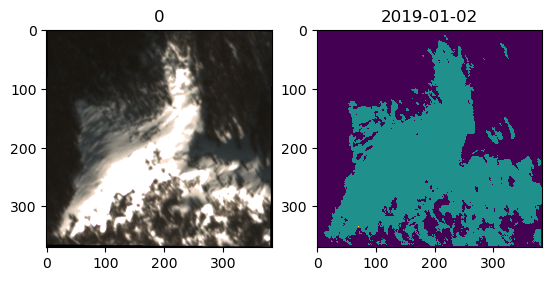

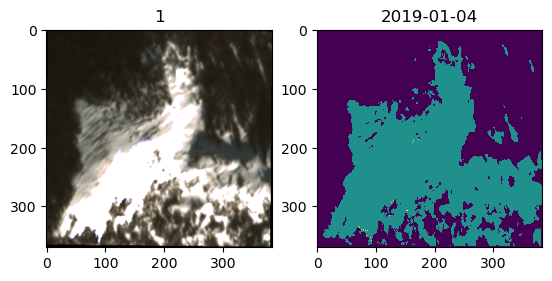

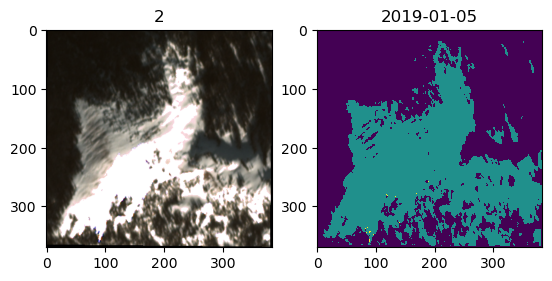

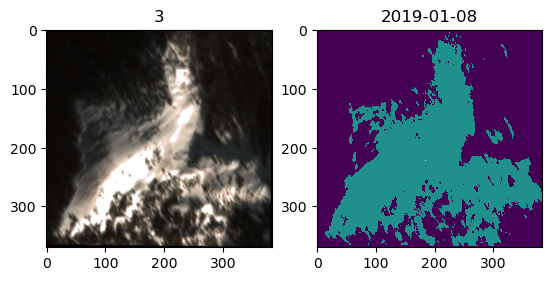

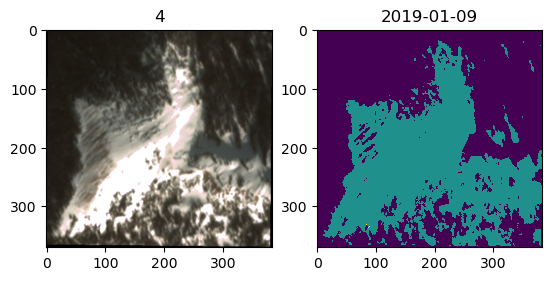

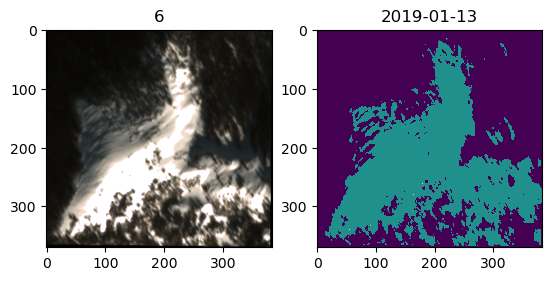

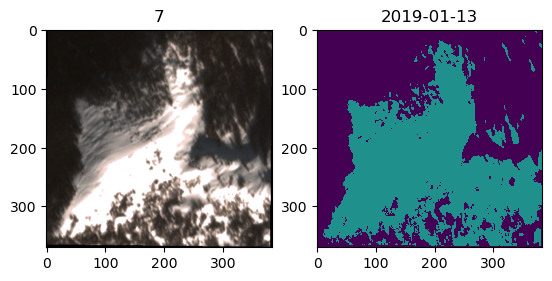

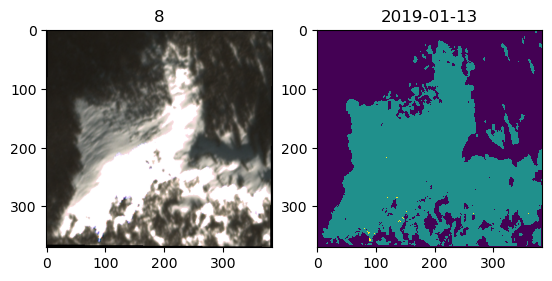

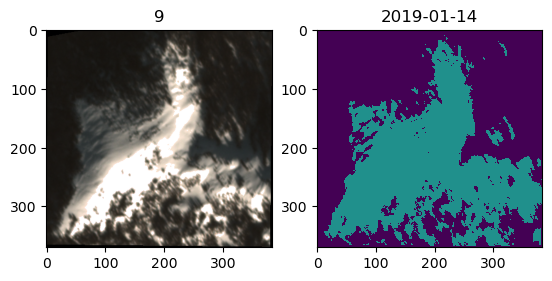

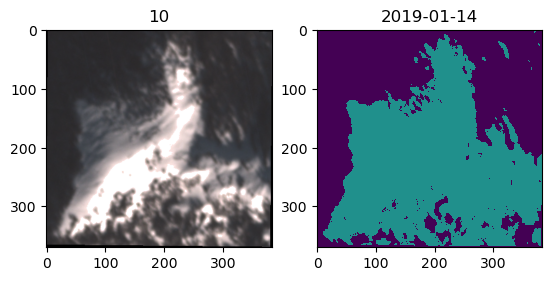

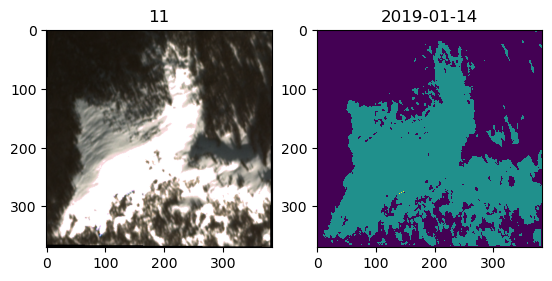

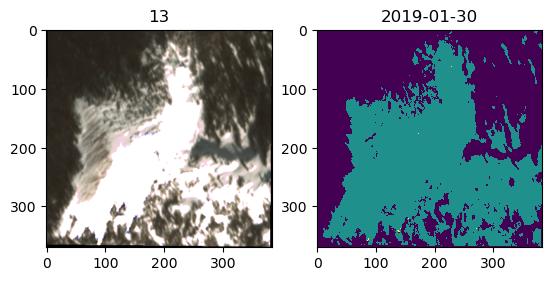

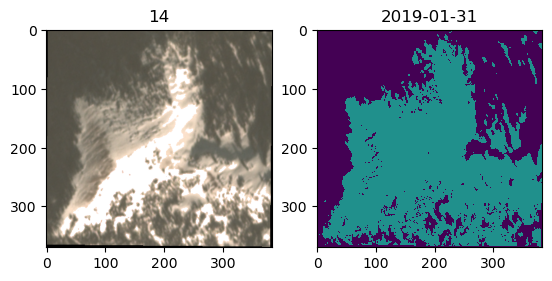

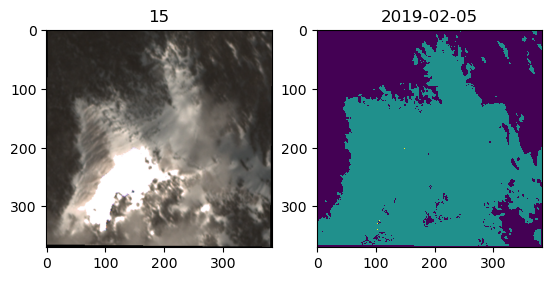

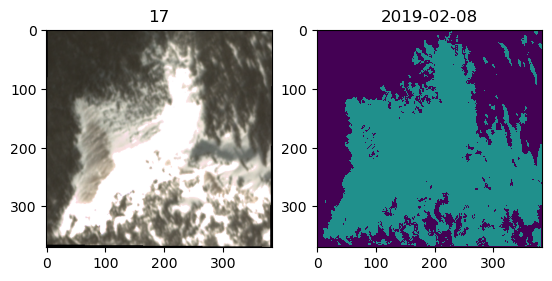

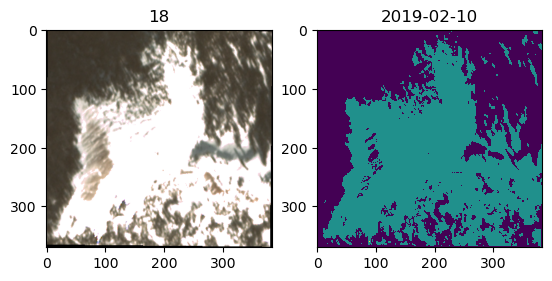

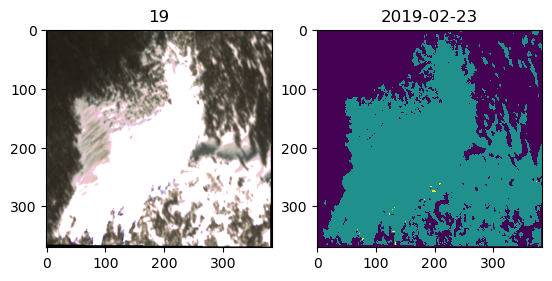

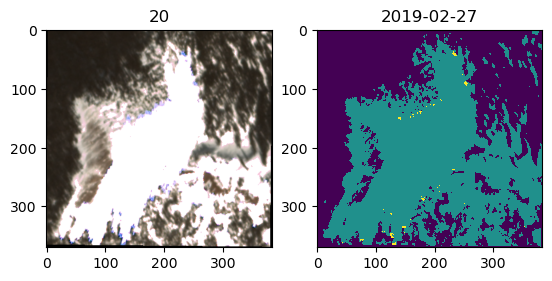

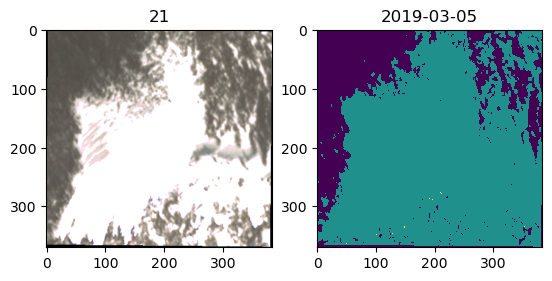

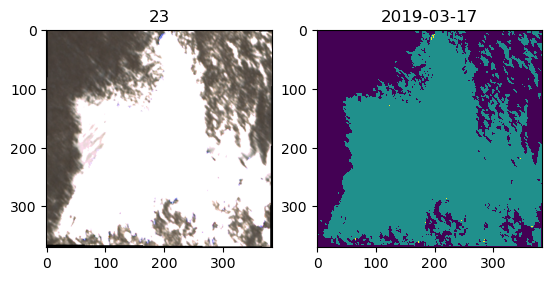

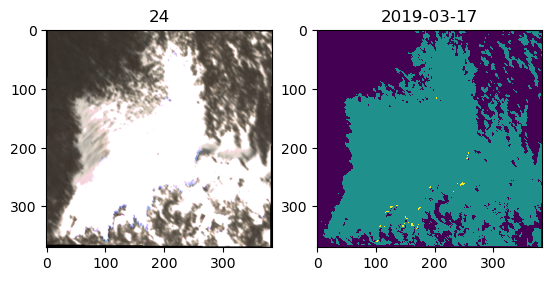

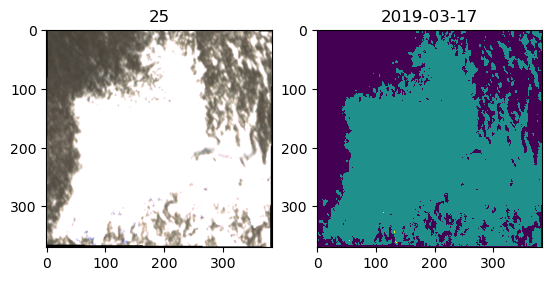

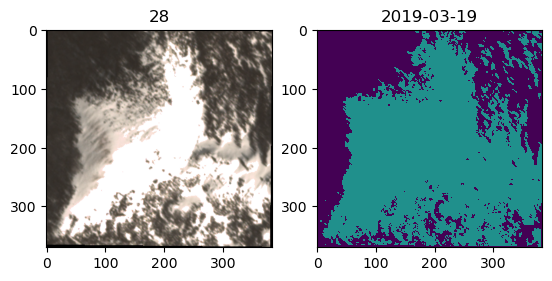

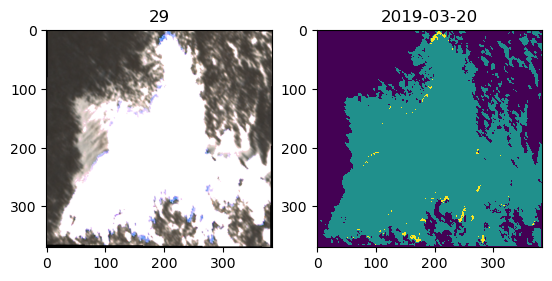

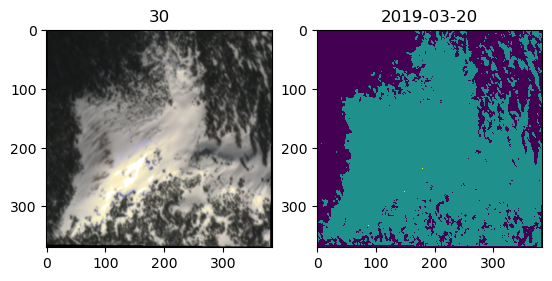

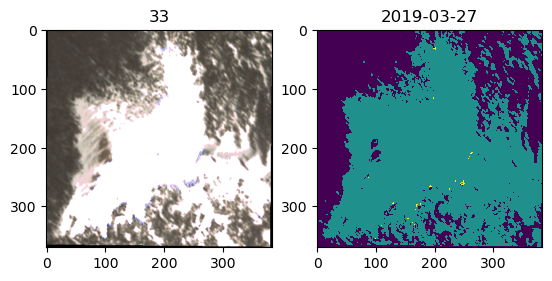

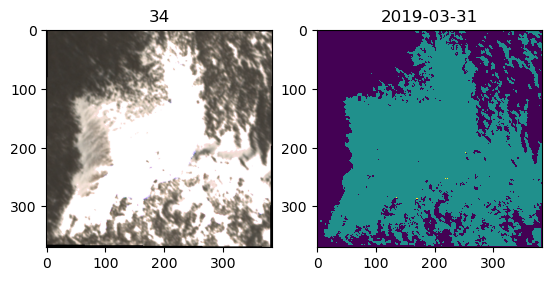

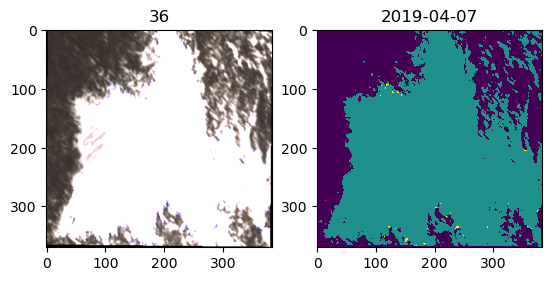

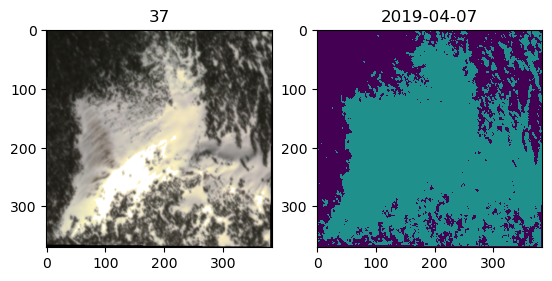

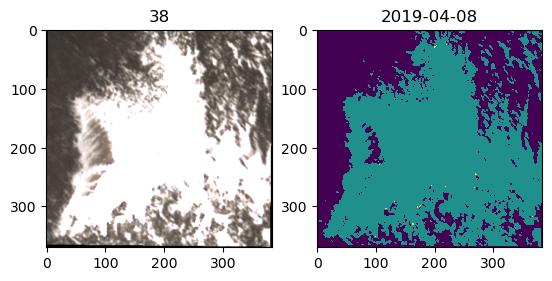

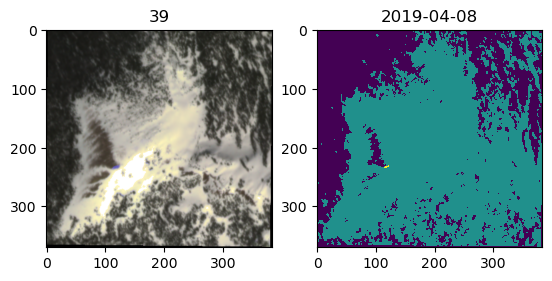

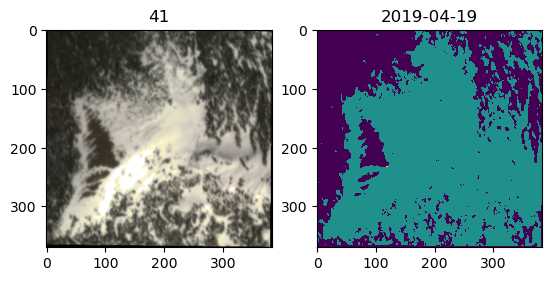

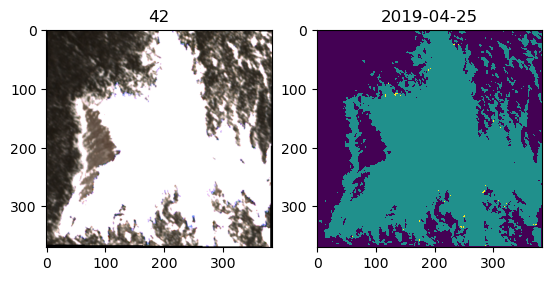

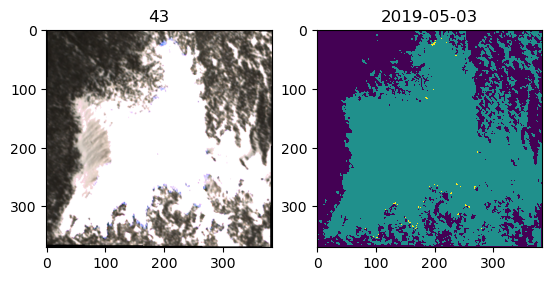

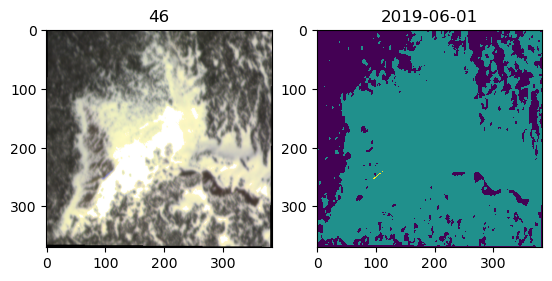

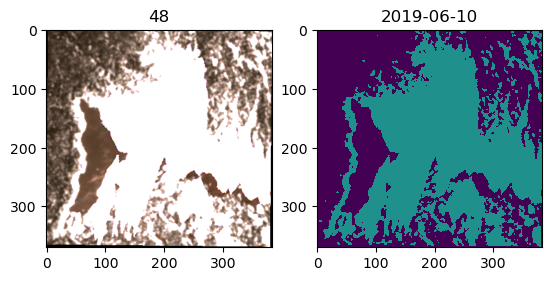

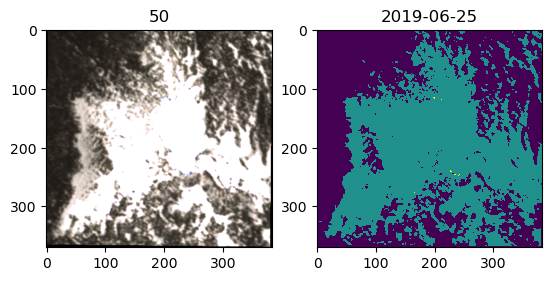

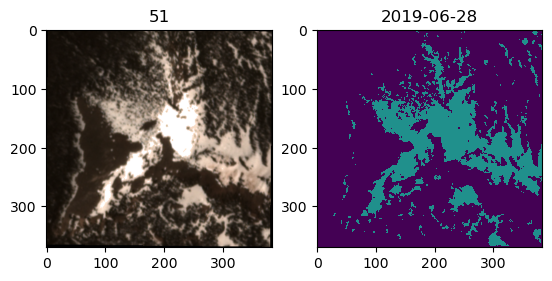

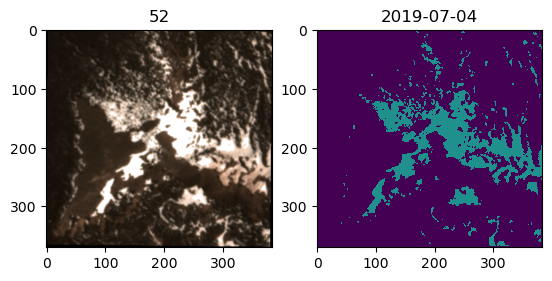

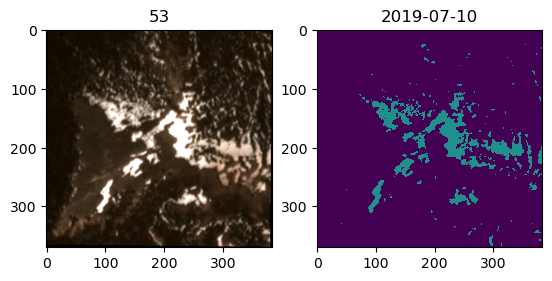

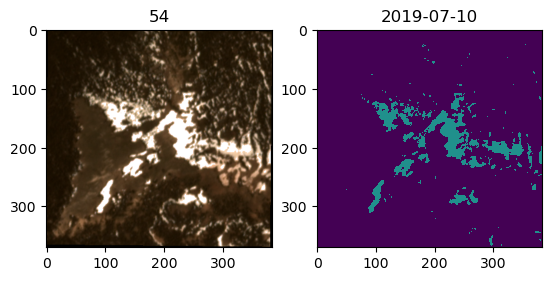

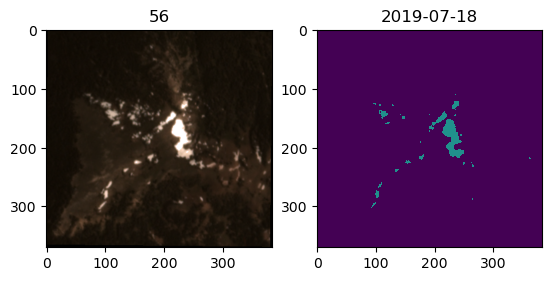

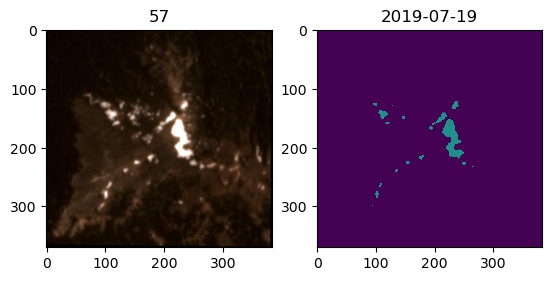

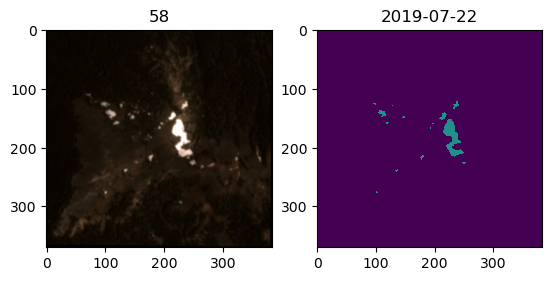

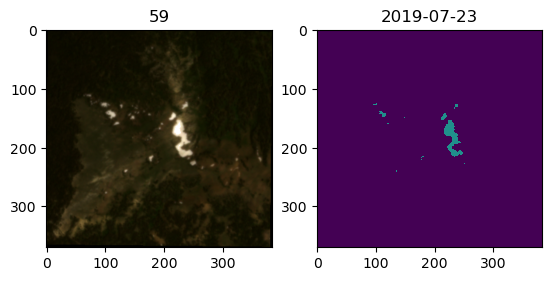

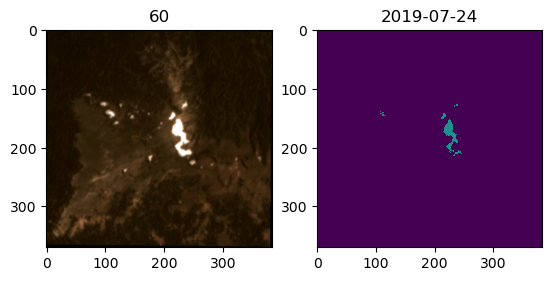

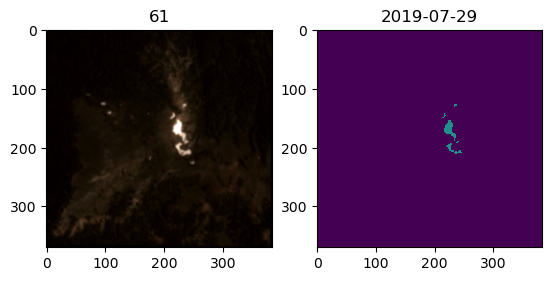

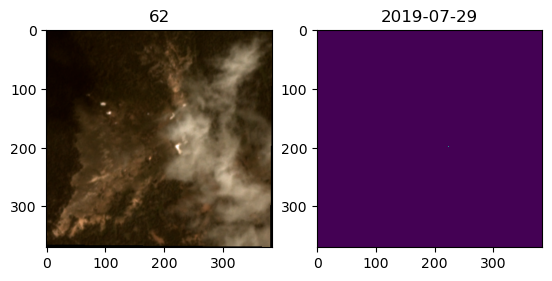

In [13]:
for dCount,direcc in enumerate(subdirecs):
    try:
        if dCount not in filtered_scenes:
            fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
            outfile = fname.split('/')[-1].split('_')
            outfile = data_direc+'self_classified/SCA/'+outfile[0]+'_'+outfile[1]+'_SCA.tif'
            print(outfile)
            
            # _ = run_sca_prediction_band(fname,outfile,nodata_flag,model)
            classified = run_sca_prediction_band_selfClassify(fname,outfile,model,saveData)
            rgb_image = rxr.open_rasterio(fname)
            _,_,_,_,rgb_image = calc_rgb(rgb_image)
    
            fg,ax = plt.subplots(1,2)
            ax = np.ravel(ax)
            ax[0].imshow(rgb_image,cmap='gray')
            ax[1].imshow(classified,vmin=0,vmax=2,interpolation='none')
            ax[0].set_title(dCount)
            ax[1].set_title(dtt[dCount])
            # break
    except:
        print('tif data error')

In [14]:
# filtered_scenes = [5,12,16,22,26,27,31,32,35,40,44,45,47,49,55]

In [11]:
# classified = run_sca_prediction_band_selfClassify(fname,outfile,nodata_flag,model)

f_raster = fname

with rasterio.open(f_raster, 'r') as ds:
    arr = ds.read()  # read all raster values
        
print("Image dimension:".format(), arr.shape)  # 
X_img = pd.DataFrame(arr.reshape([4,-1]).T)
X_img.columns = ['b','g','r','nir']
X_img
y_img = model.predict(X_img)

out_img = pd.DataFrame()
out_img['label'] = y_img
# out_img['label'] = np.where(X_img['nodata_flag'] == -1, np.nan, out_img['label'])

# Reshape our classification map
img_prediction = out_img['label'].to_numpy().reshape(arr[0,:, :].shape)

Image dimension: (4, 359, 378)


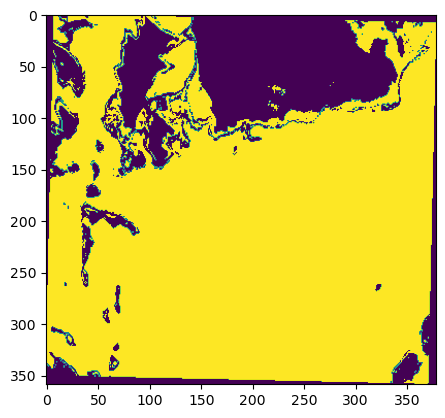

In [12]:
plt.imshow(img_prediction)

In [19]:
# fn = ['/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/GIN/20220407_182228_96_24a4/ce6ad317-76a7-4c9b-b241-1d6a733b9a42/PSScene/20220407_182228_96_24a4_3B_AnalyticMS_SR_clip.tif']
fn = ['/Users/jpflug/Documents/Projects/cubesatReanaly/Data/Meadows/GIN/20220323_174833_44_2420/61a6723d-1ce0-42b3-ba4f-4b52fb2db0e5/PSScene/20220323_174833_44_2420_3B_AnalyticMS_SR_clip.tif']
f_out = 'test.tif'
nodata_flag = 9
model = joblib.load('MLmodels/random_forest_20220513_binary_174K.joblib')
# model = joblib.load('MLmodels/random_forest_20220513_binary_174K_fv.joblib')
# model = joblib.load('MLmodels/random_forest_20240116_binary_174K.joblib')

/Users/jpflug/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jpflug/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
def run_sca_prediction_band(f_raster, file_out, nodata_flag, model):
    # ndvi_out = os.path.dirname(file_out) + '/' +os.path.basename(file_out)[0:-8] + '_NDVI.tif'
    ndvi_out = file_out
    
    with rasterio.open(f_raster, 'r') as ds:
        arr = ds.read()  # read all raster values
        
    print("Image dimension:".format(), arr.shape)  # 
    X_img = pd.DataFrame(arr.reshape([4,-1]).T)
    X_img = X_img/10000 # scale surface reflectance to 0-1
    X_img.columns = ['blue','green','red','nir']
    # model.fit(X,y)
    y_img = model.predict(X_img)

    X_img['ndvi'] = (X_img['nir']-X_img['red'])/(X_img['nir']+X_img['red'])
    X_img[X_img['ndvi']< -1.0]['ndvi'] = -1.0
    X_img[X_img['ndvi']> 1.0]['ndvi'] = 1.0
    X_img['ndvi'] = np.where(np.isfinite(X_img['ndvi']), X_img['ndvi'], 0) # fill nan by NA
    
    X_img['nodata_flag'] = np.where(X_img['blue']==0, -1, 1)
    X_img['ndvi_nan'] = (X_img['nir']-X_img['red'])/(X_img['nir']+X_img['red'])


    out_img = pd.DataFrame()
    out_img['label'] = y_img
    out_img['ndvi'] = (X_img.nir - X_img.red)/(X_img.nir + X_img.red)
    out_img['label'] = np.where(X_img['nodata_flag'] == -1, np.nan, out_img['label'])
    out_img['label'] = np.where(np.isnan(X_img['ndvi_nan']), np.nan, out_img['label'])


    # Reshape our classification map
    img_prediction = out_img['label'].to_numpy().reshape(arr[0,:, :].shape)
    img_ndvi = out_img['ndvi'].to_numpy().reshape(arr[0,:, :].shape)
    
    with rasterio.open(
        file_out, "w",
        driver = "GTiff",
        transform = ds.transform,
        dtype = rasterio.float32,
        count = 1,
        crs = ds.crs,
        width = ds.width,
        height = ds.height) as dst:
            dst.write(img_prediction, indexes = 1)
            
    return img_prediction
        

In [21]:
for i in range(len(fn)):
    sca = run_sca_prediction_band(fn[i], f_out, nodata_flag, model)

Image dimension: (4, 796, 675)


/Users/jpflug/opt/anaconda3/envs/pangeo/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


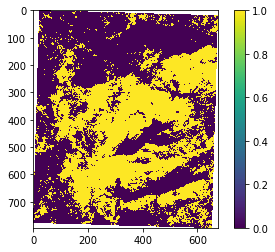

In [22]:
# test = np.zeros(img_ndvi.shape)
# test[img_ndvi  0.2] = 1
plt.imshow(sca,interpolation='none')
plt.colorbar()